# Simulation framework for *Littorina* project

To start analysis load packages, styles and initialize (run) functions

## Loading packages

In [1]:
import msprime
import numpy as np
import scipy
from IPython.display import SVG
import tskit
#import allel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import ternary #
import collections
import random
import demesdraw 

import matplotlib as ml
%matplotlib inline
font = {'family' : 'Sans', 'weight' : 'normal','size': 16}
ml.rc('font', **font)
ml.rcParams['figure.figsize'] = (5.0, 5.0)
ml.rcParams['text.usetex'] =False
ml.rc('font', family='serif',size=16)

In [2]:
def set_demography(t1,t2,t3,mig_rate,Ne):
    demography = msprime.Demography()
    
    #initializing populations
    demography.add_population(name="P1", initial_size=Ne)
    demography.add_population(name="P2", initial_size=Ne)
    demography.add_population(name="P3", initial_size=Ne)
    demography.add_population(name="O", initial_size=Ne)
    demography.add_population(name="P12", initial_size=Ne)
    demography.add_population(name="P123", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    
    #adding split times
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")
    
    #setting up gene flow
    demography.set_migration_rate("P3", "P2", mig_rate)
    
    #Simultanious test
    ml.rcParams['figure.figsize'] = (8.0, 5.0)
    graph = msprime.Demography.to_demes(demography)
    fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
    demesdraw.tubes(graph, ax=ax, seed=1)
    plt.show()

    return demography

def set_demography_s(t1,t2,t3,mig_rate,Ne):
    demography = msprime.Demography()
    
    #initializing populations
    demography.add_population(name="P1", initial_size=Ne)
    demography.add_population(name="P2", initial_size=Ne)
    demography.add_population(name="P3", initial_size=Ne)
    demography.add_population(name="O", initial_size=Ne)
    demography.add_population(name="P12", initial_size=Ne)
    demography.add_population(name="P123", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    
    #adding split times
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")
    
    #setting up gene flow
    demography.set_migration_rate("P3", "P2", mig_rate)

    return demography

def tern_plot(data):
    # Set up the figure.
    fig, tax = ternary.figure(scale=100)
    fig.set_size_inches(10, 9)

    # Plot points.
    tax.scatter(data,color="green",alpha=0.3)

    # Axis labels. (See below for corner labels.)
    fontsize = 14
    offset = 0.08
    tax.left_axis_label("T control %", fontsize=fontsize, offset=offset)
    tax.right_axis_label("T species %", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("T reproduction %", fontsize=fontsize, offset=-offset)
    tax.set_title("Ternary Framework", fontsize=20)

    # Decoration.
    tax.boundary(linewidth=0.1)
    tax.gridlines(multiple=10, color="grey")
    tax.ticks(axis='lbr', linewidth=0.2, multiple=20)
    tax.get_axes().axis('off')
    
def simulate_windows(num_replicates,demography):
    ancestry_reps = msprime.sim_ancestry(samples={"P1": 1, "P2": 1, "P3": 1, "O": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/10000))
        yield mutated_ts
        
        
def produce_ranks(ts_reps):
    ranks=[]
    for replicate_index, ts in enumerate(ts_reps):
        for t in ts.trees():
            ranks+=[t.rank()]
    return ranks
        
def summarize_ranks(num_replicates,ranks):    
    topo_weight= []
    topS_count = []
    topC_count = []
    topR_count = []

    rank_dict=collections.Counter(ranks)

    for key, value in rank_dict.items():
        if key == (4,0) or key == (3,11) or key == (3,8) or key == (3,0) or key == (3,3):
            topS_count.append(value)
            #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
            # TOPOLOGY C
        elif key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
            # TOPOLOGY R
    count_array=[(sum(topR_count)/num_replicates)*100, sum(topS_count)/num_replicates*100, sum(topC_count)/num_replicates*100]
    return count_array

def make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate):
    topo_sum=[]
    for i in range(num_data_points):
        ranks=produce_ranks(simulate_windows(num_replicates,set_demography_s(t1,t2,t3,mig_rate,Ne)))
        topo_sum.append(summarize_ranks(num_replicates,ranks))
    return topo_sum

## Simulation set up

### Setting up demographic models

`set_demography(t1,t2,t3,mig_rate,Ne)`

Allows to define custom demographic models similar to Martin et al.
Function returns msprime.Demography() object as well as visualization and summary of the model

Parameters to specify are:
- three split times $t_1$(=$t_{12}$), $t_2$(=$t_{23}$), $t_3$(split time with outgroup)
- uniform $N_e$ for each of the identical in all populations
- `mig_rate` migration rate between $P_3$ and $P_2$ (can be set to 0)


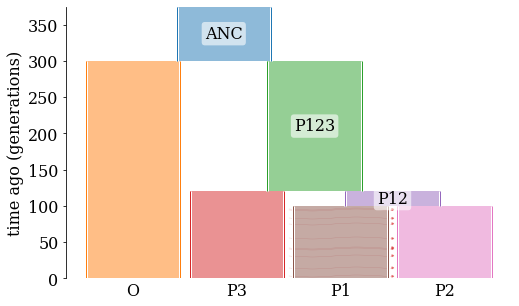

Demography(populations=[Population(initial_size=1000, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=1000, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=1000, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=1000, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=1000, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=100, initially_active=False, id=4), Population(initial_size=1000, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=120, initially_active=False, id=5), Population(initial_size=1000, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=300, initially_active=False, id=6)], events=[PopulationSplit(time=100, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=120, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=300, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]]))

In [163]:
#Example of the usage: no migration
set_demography(100,120,300,0.1,1000)

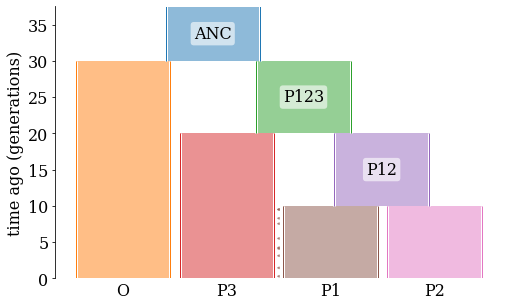

Demography(populations=[Population(initial_size=100, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=100, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=100, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=100, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=4), Population(initial_size=100, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=5), Population(initial_size=100, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=30, initially_active=False, id=6)], events=[PopulationSplit(time=10, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=20, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=30, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]]))

In [26]:
#Example of the usage: migration at rate 0.1
set_demography(10,20,30,0.1,100)

### Setting up simulations

`simulate_windows(num_replicates,demography)`

Simulates one window with length 10000 (10kb).  
Simulation consists of two steps. First creates ancestry of the sample. One haploid individual is sampled from each of the populations (((P1,P2),P3),O). The second step adds mutations with the rate **1/10000** (note: clarify)

> Note: We assume no recombination within the window, recombination is not included in the simulation

Parameters to specify are:
- `num_replicates`
- `demography` can be specified using the function above

In [133]:
def simulate_windows(num_replicates,demography):
    ancestry_reps = msprime.sim_ancestry(samples={"P1": 1, "P2": 1, "P3": 1, "O": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/100000))
        yield mutated_ts

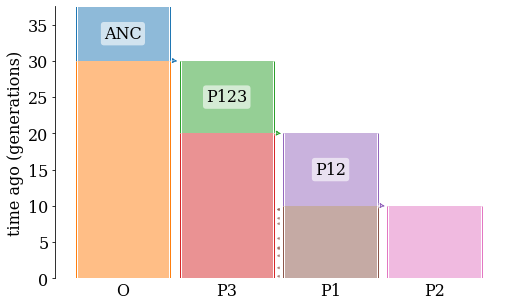

Number of mutations on the tree 2266


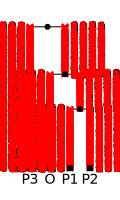

Number of mutations on the tree 4903


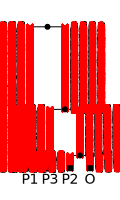

Number of mutations on the tree 5519


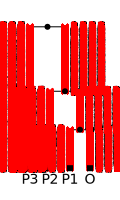

In [14]:
num_replicates = 3
windows=simulate_windows(num_replicates,set_demography(10,20,30,0.1,1000))
for replicate_index, ts in enumerate(windows):
    for t in ts.trees():
        print("Number of mutations on the tree "+str(t.num_mutations))
        display(SVG(t.draw_svg(node_labels={0: "P1", 1: "P2", 2: "P3", 3 : "O"}, order="tree", size=(120, 200))))

### Summarizing tree sequences, ternary plot

Simulations above will output replicates of tree sequences (all in one iterable object). In this section we develop the way to efficiently output the result of simulation and calculate values for ternary plots.

Simple simulation outputs the tree sequence object:

In [8]:
ts = msprime.sim_ancestry(4)
ts

For the ternary plot we only need information about tree topologies, which are compactly stored in "rank" parameter. See tskit manual for the details: https://tskit.dev/tskit/docs/latest/topological-analysis.html

Below we visualize ranks corresponding to **Topology r** (node names now correspond to Figure 2 of the manuscript):

Topology r
Visualizing rank (3, 2)


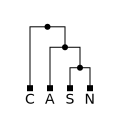

Visualizing rank (3, 4)


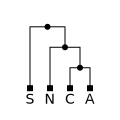

Visualizing rank (3, 9)


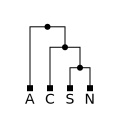

Visualizing rank (3, 7)


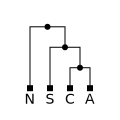

Visualizing rank (4, 2)


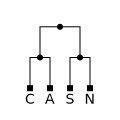

In [122]:
print("Topology r")
for rank in [(3,2), (3, 4), (3, 9),(3,7), (4, 2)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

**Topology c**:

Topology c
Visualizing rank (4, 1)


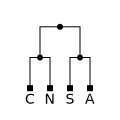

Visualizing rank (3, 10)


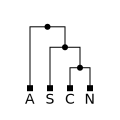

Visualizing rank (3, 6)


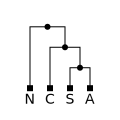

Visualizing rank (3, 5)


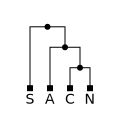

Visualizing rank (3, 1)


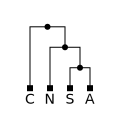

In [121]:
print("Topology c")
for rank in [(4,1), (3, 10), (3, 6),(3,5), (3, 1)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

**Topology s**:

Topology s
Visualizing rank (4, 0)


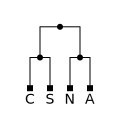

Visualizing rank (3, 11)


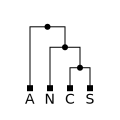

Visualizing rank (3, 8)


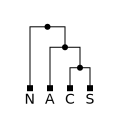

Visualizing rank (3, 0)


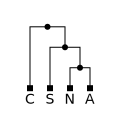

Visualizing rank (3, 3)


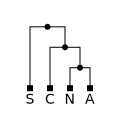

In [120]:
print("Topology s")
for rank in [(4,0), (3, 11), (3, 8),(3,0), (3, 3)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

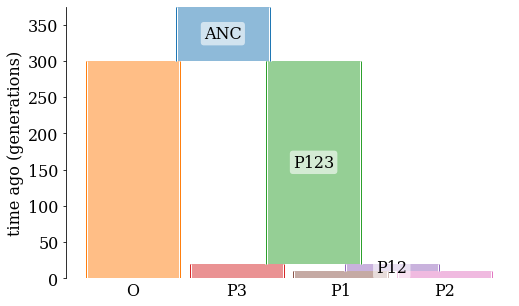

[(3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 9),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 10),
 (4, 1),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 9),
 (4, 2),
 (3, 11),
 (3, 11),
 (3, 11),
 (4, 1),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 9),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (4, 1)]

In [164]:
windows=simulate_windows(100,set_demography(10,20,300,0,100))
produce_ranks(windows)

Next we gather rank information from all the iterations: 

`produce_ranks` outputs ranks from all simulated windows

`summarize_ranks(num_replicates,ranks)`   
Counts three types of topologies and produces a vector  
`[%topology r,%topology s,%topology c]` 

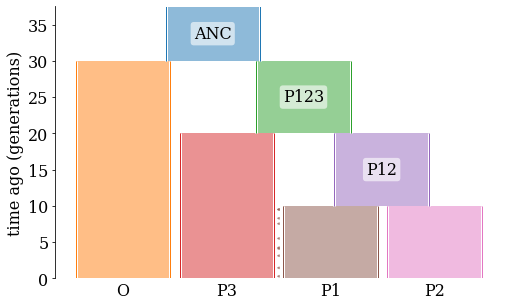

[25.0, 36.0, 39.0]

In [123]:
ranks=produce_ranks(simulate_windows(100,set_demography(10,20,30,0.1,100)))
summarize_ranks(100,ranks)    

`tern_plot(data)`

Plots a ternary graph given the data in format `three_points=[[33,33,33],[0,100,0],[70,10,20]]`

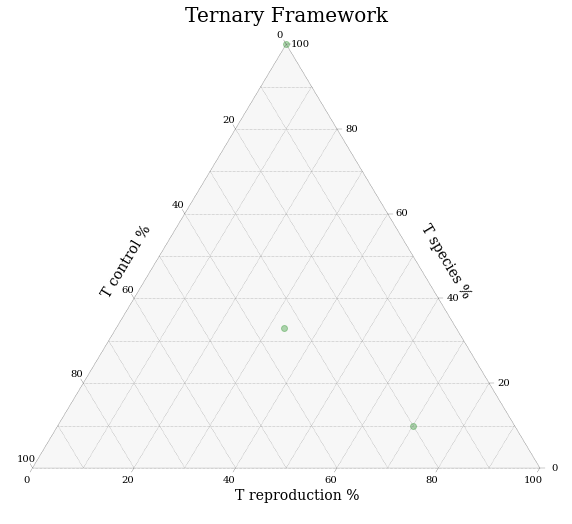

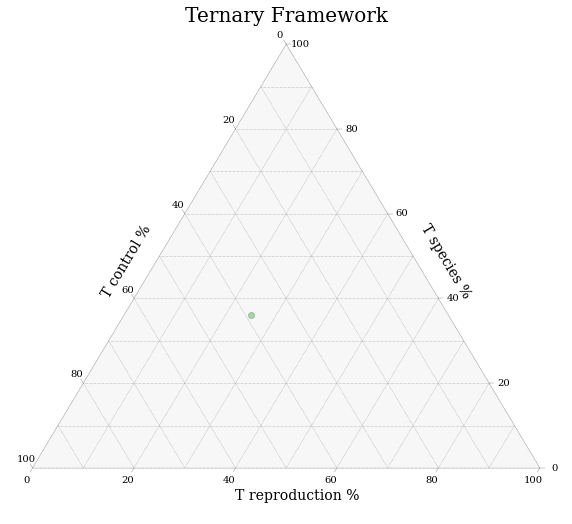

In [126]:
tern_plot([[33,33,33],[0,100,0],[70,10,20]])
tern_plot([summarize_ranks(100,ranks)])

### Output asymmetry statistics

### Creating data set

We can now combine functions above and generate multiple data points:

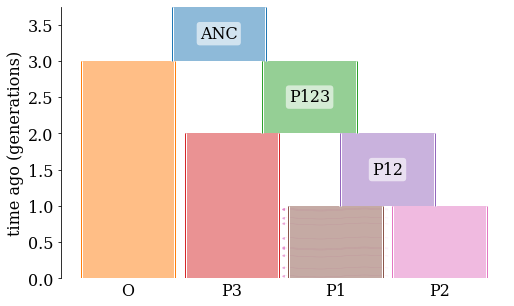

[32.0, 28.999999999999996, 39.0]


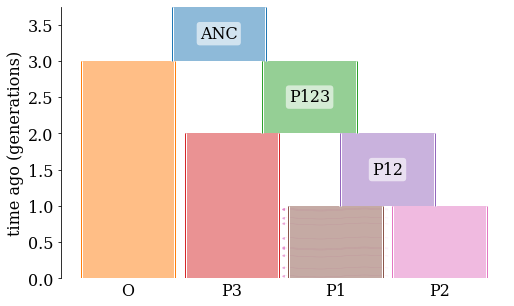

[42.0, 32.0, 26.0]


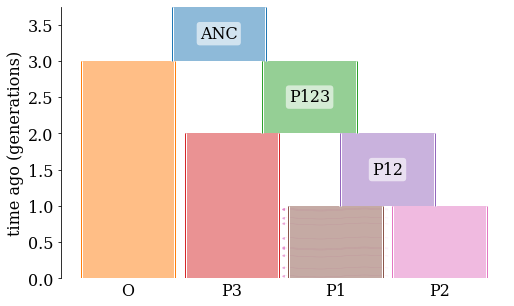

[28.000000000000004, 38.0, 34.0]


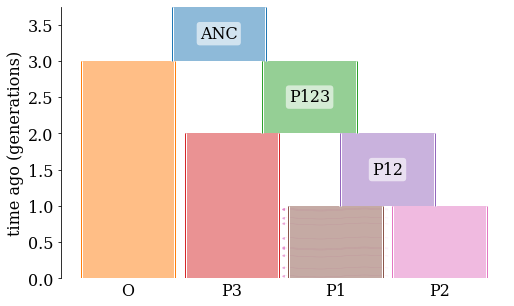

[39.0, 28.999999999999996, 32.0]


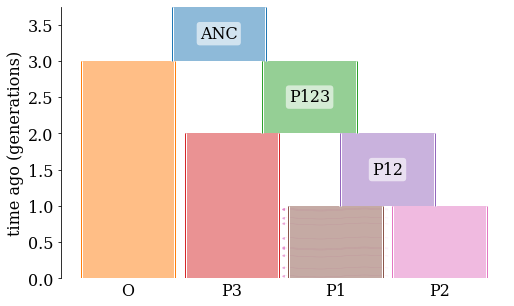

[28.000000000000004, 33.0, 39.0]
[[32.0, 28.999999999999996, 39.0], [42.0, 32.0, 26.0], [28.000000000000004, 38.0, 34.0], [39.0, 28.999999999999996, 32.0], [28.000000000000004, 33.0, 39.0]]


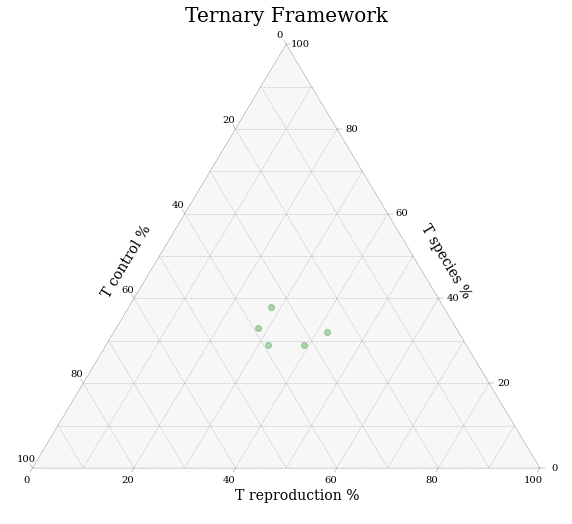

In [4]:
topo_sum=[]
for i in range(5):
    ranks=produce_ranks(simulate_windows(100,set_demography(1,2,3,0.05,1000)))
    print(summarize_ranks(100,ranks))
    topo_sum.append(summarize_ranks(100,ranks))
    
print(topo_sum)
tern_plot(topo_sum)

We can now generalize this into one function and silence visualization of the model

`make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)`  
    All the arguments like before

[[25.0, 33.0, 42.0]]


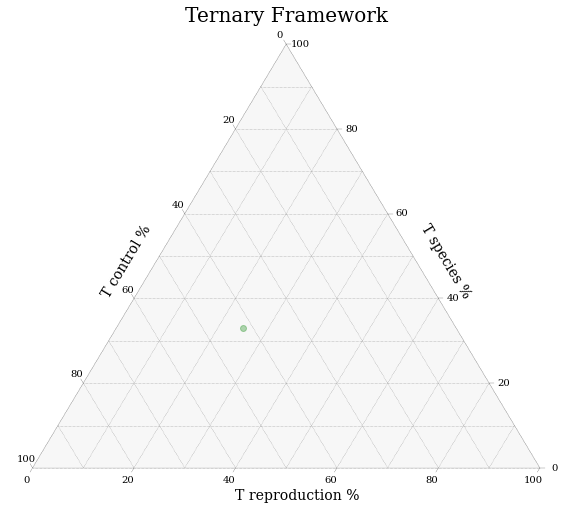

In [5]:
num_data_points=1
num_replicates=100
t1=10
t2=20
t3=30
Ne=1000
mig_rate=0.6

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
print(data)

#Option to save raw outputs
#f = open("/Users/dshipilina/GitHub/LittorinaBrooding/results.tsv", "x")
#f.write(str(data))
#f.close()

tern_plot(data)

## Analysis

We start from model without the gene flow and visualize influence of the split time: 

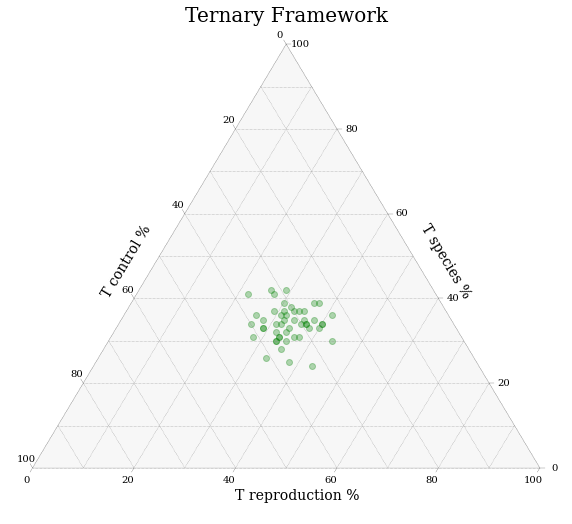

In [33]:
num_data_points=50
num_replicates=100
t1=10
t2=20
t3=30
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
#print(data)

#Option to save raw outputs
#f = open("/Users/dshipilina/GitHub/LittorinaBrooding/results.tsv", "x")
#f.write(str(data))
#f.close()

tern_plot(data)
#Option to save plot
#plt.savefig("/Users/dshipilina/GitHub/LittorinaBrooding/null10_20_120_"+run_name+".pdf",bbox_inches="tight")

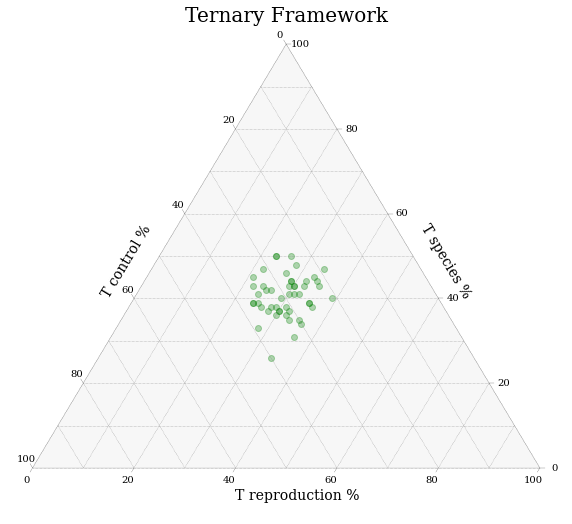

In [36]:
#Increasing the split times proportionally

num_data_points=50
num_replicates=100
t1=100
t2=200
t3=300
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)

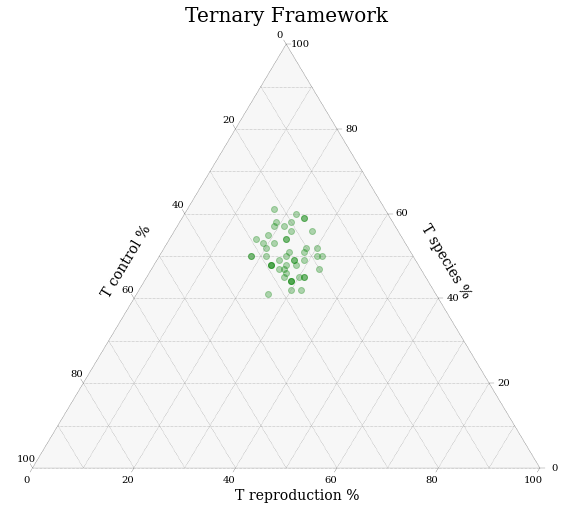

In [38]:
#Increasing the split times proportionally

num_data_points=50
num_replicates=100
t1=100
t2=400
t3=500
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)

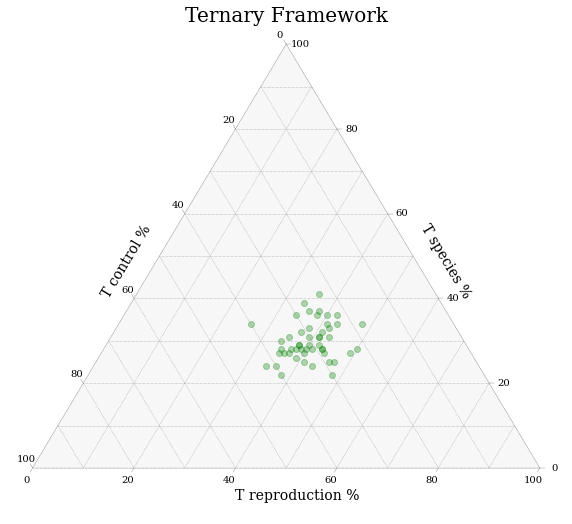

In [39]:
#Adding gene flow

num_data_points=50
num_replicates=100
t1=100
t2=200
t3=500
Ne=1000
mig_rate=0.6

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)